In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

np.set_printoptions(linewidth=1000)

In [2]:
import tensorflow_datasets as tfds

X, Y = tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

print('X.shape =',X.shape)
print('np.unique(Y) =',np.unique(Y))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.LAU85B_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
X.shape = (5000, 150, 150, 3)
np.unique(Y) = [0 1 2 3 4 5 6 7]


In [3]:
# prompt: rain–test split
# Use train_test_split (test_size = 0.2, stratify = Y, random_state = SEED).
# Persist the split indices in data/split/train_idx.npy & data/split/test_idx.npy so every later notebook loads exactly the same images.

import numpy as np
from sklearn.model_selection import train_test_split
import os

SEED = 42 # You can choose any integer for the random state

# Perform the train-test split
train_idx, test_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2, stratify=Y, random_state=SEED)

# Create the directory if it doesn't exist
output_dir = 'data/split/'
os.makedirs(output_dir, exist_ok=True)

# Save the indices
np.save(os.path.join(output_dir, 'train_idx.npy'), train_idx)
np.save(os.path.join(output_dir, 'test_idx.npy'), test_idx)

print("Train indices saved to data/split/train_idx.npy")
print("Test indices saved to data/split/test_idx.npy")
print("Number of training samples:", len(train_idx))
print("Number of testing samples:", len(test_idx))


Train indices saved to data/split/train_idx.npy
Test indices saved to data/split/test_idx.npy
Number of training samples: 4000
Number of testing samples: 1000


In [4]:
# prompt: Save raw images (optional but handy)
# Write JPEGs to data/raw/train/<label>/ and data/raw/test/<label>/ so later steps can use PIL if desired.

import numpy as np
from PIL import Image

# Define the base directory for raw images
raw_data_dir = 'data/raw/'

# Create directories for train and test splits and labels
for split in ['train', 'test']:
    for label in np.unique(Y):
        os.makedirs(os.path.join(raw_data_dir, split, str(label)), exist_ok=True)

# Save training images
print("Saving training images...")
for i in train_idx:
    img = Image.fromarray(X[i])
    label = Y[i]
    img.save(os.path.join(raw_data_dir, 'train', str(label), f'{i}.jpg'))

# Save testing images
print("Saving testing images...")
for i in test_idx:
    img = Image.fromarray(X[i])
    label = Y[i]
    img.save(os.path.join(raw_data_dir, 'test', str(label), f'{i}.jpg'))

print("Raw images saved.")

Saving training images...
Saving testing images...
Raw images saved.


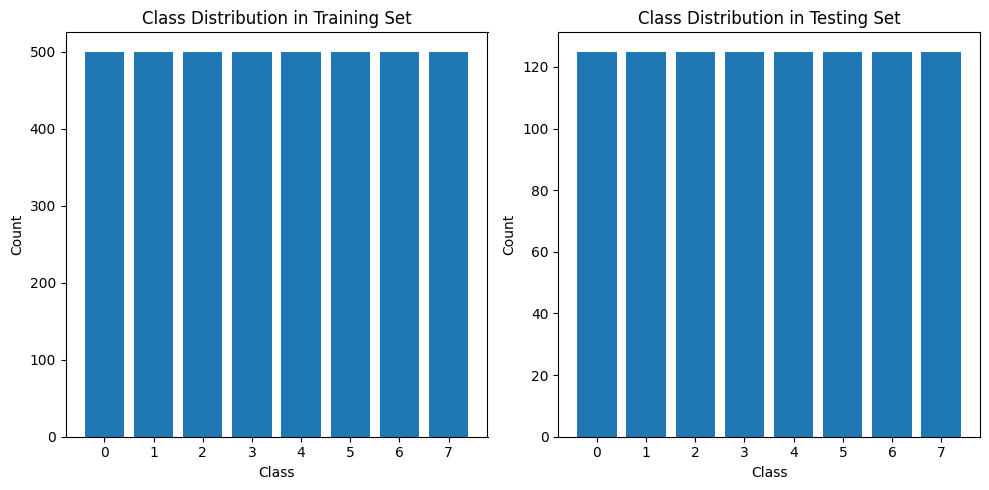

Training set class counts: [500 500 500 500 500 500 500 500]
Testing set class counts: [125 125 125 125 125 125 125 125]


In [5]:
# prompt: Verify class balance with a bar chart on both splits.

import matplotlib.pyplot as plt
import numpy as np
# Verify class balance on both splits
train_labels = Y[train_idx]
test_labels = Y[test_idx]

train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels)

classes = np.unique(Y)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(classes, train_class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(classes)

plt.subplot(1, 2, 2)
plt.bar(classes, test_class_counts)
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(classes)

plt.tight_layout()
plt.show()

print("Training set class counts:", train_class_counts)
print("Testing set class counts:", test_class_counts)

In [6]:
# prompt: Set global seeds for numpy, random, and tensorflow.

import os
import random
import numpy as np
import tensorflow as tf

def set_global_seeds(seed):
    """Sets the global seeds for reproducibility."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For GPU, sometimes deterministic behavior requires more configuration
    # tf.config.experimental.enable_deterministic_ops(True) # This can impact performance


SEED = 42 # You can choose any integer for the random state
set_global_seeds(SEED)

# The rest of your code follows here...

PART 1 — Exploratory Data Analysis (EDA A)

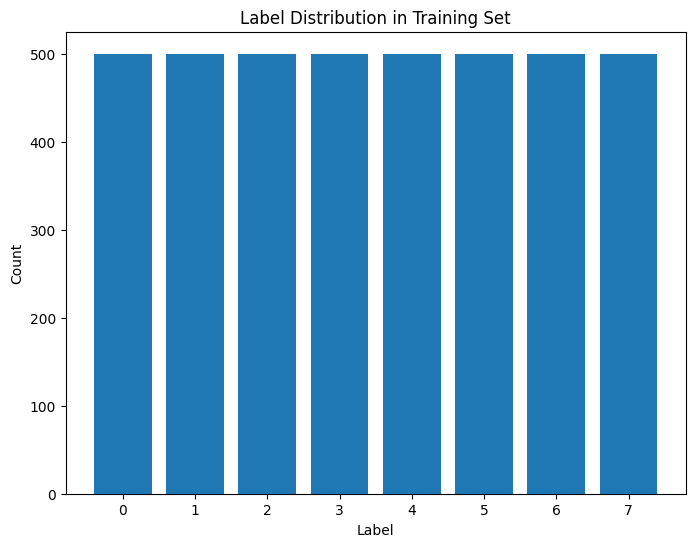

In [7]:
# prompt: Bar chart of label distribution on train only.

import matplotlib.pyplot as plt
import numpy as np
# Get the class distribution for the training set
train_labels = Y[train_idx]
train_class_counts = np.bincount(train_labels)
classes = np.unique(Y)

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(classes, train_class_counts)
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(classes)
plt.show()

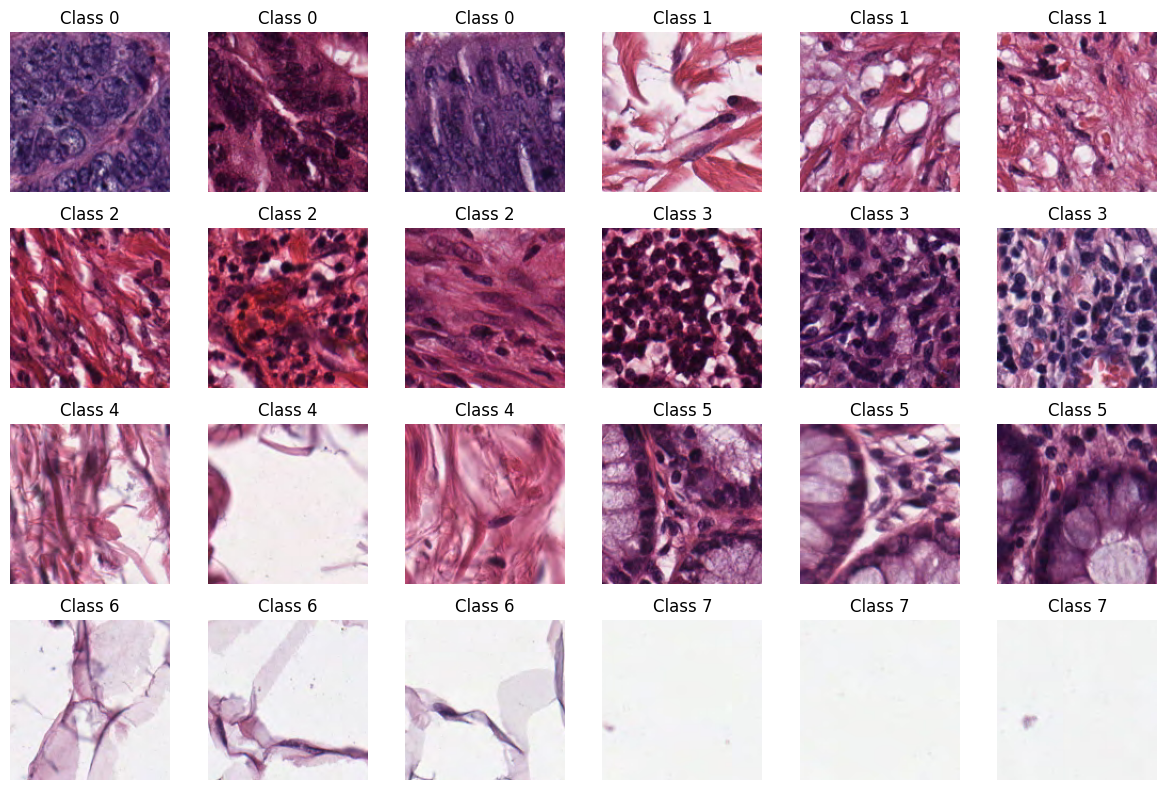

In [8]:
# prompt: Display ≥ 3 random sample tiles per class in a 4 × 6 grid.

import matplotlib.pyplot as plt
import numpy as np
# Display sample tiles
n_samples_per_class = 3
n_classes = len(np.unique(Y))
n_cols = 6
n_rows = int(np.ceil(n_samples_per_class * n_classes / n_cols))

plt.figure(figsize=(12, 2 * n_rows))

for label in np.unique(Y):
  class_indices = np.where(Y == label)[0]
  sample_indices = np.random.choice(class_indices, min(n_samples_per_class, len(class_indices)), replace=False)
  for i, idx in enumerate(sample_indices):
    plot_index = label * n_samples_per_class + i + 1
    plt.subplot(n_rows, n_cols, plot_index)
    plt.imshow(X[idx])
    plt.title(f'Class {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.6 MB/s eta 0:00:00
Shape of flattened training images: (4000, 67500)
Shape after PCA (50 components): (4000, 50)
Shape after t-SNE (2 components): (4000, 2)


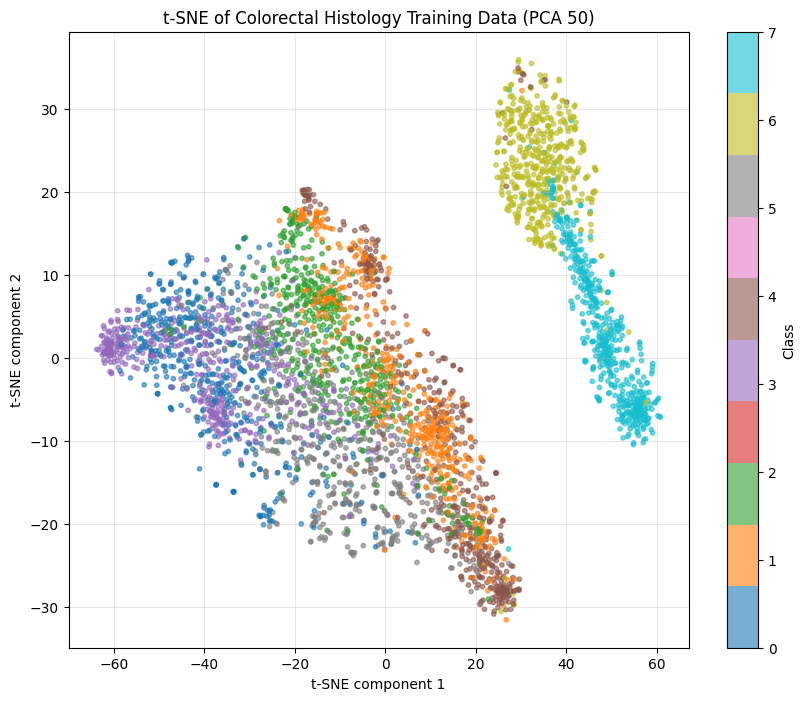

In [9]:
# prompt: Flatten all train images → PCA 50 → t-SNE 2 ➜ scatter plot coloured by class; short Markdown discussion.
# Notebook must end clean and executed.

import matplotlib.pyplot as plt
!pip install scikit-learn openTSNE

from sklearn.decomposition import PCA
from openTSNE import TSNE

# Flatten the training images
train_images_flat = X[train_idx].reshape(X[train_idx].shape[0], -1)
train_labels_subset = Y[train_idx] # Use the training labels

print("Shape of flattened training images:", train_images_flat.shape)

# Apply PCA
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=SEED)
train_images_pca = pca.fit_transform(train_images_flat)

print(f"Shape after PCA ({n_components_pca} components):", train_images_pca.shape)

# Apply t-SNE
n_components_tsne = 2
tsne = TSNE(n_components=n_components_tsne, random_state=SEED, n_jobs=-1)
train_images_tsne = tsne.fit(train_images_pca)

print(f"Shape after t-SNE ({n_components_tsne} components):", train_images_tsne.shape)

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels_subset, cmap='tab10', alpha=0.6, s=10)
plt.title('t-SNE of Colorectal Histology Training Data (PCA 50)')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.show()


PART 2 — Feature pipelines & extra EDA


Processing pipeline: Downsample_Flatten
  Feature shape: (4000, 3072)


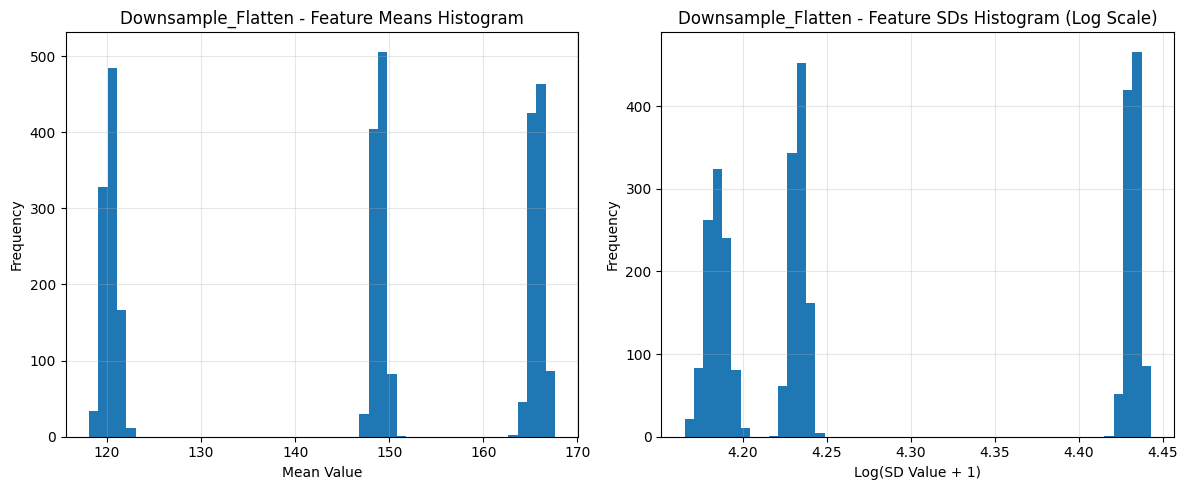

  Fitting StandardScaler...
  StandardScaler fitted.
  Running t-SNE on 2500 random samples...
  t-SNE data shape: (2500, 3072)


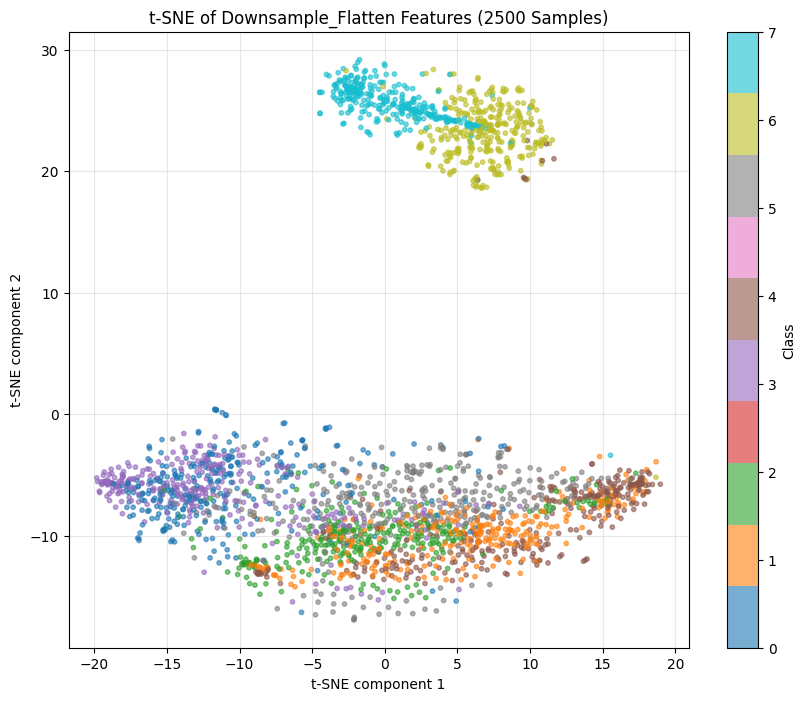


Processing pipeline: Raw_Flatten_PCA
  Feature shape: (4000, 256)


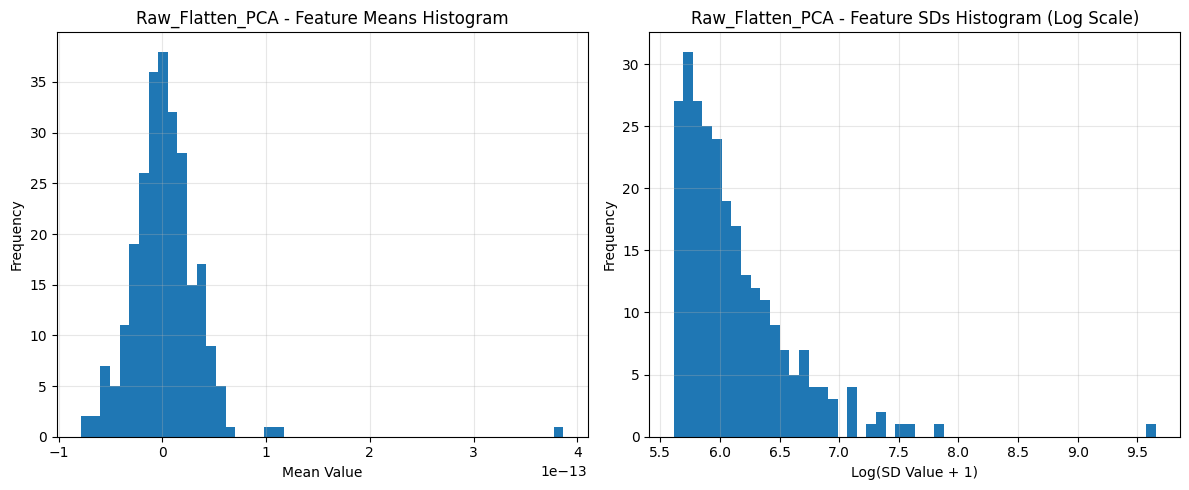

  Fitting StandardScaler...
  StandardScaler fitted.
  Running t-SNE on 2500 random samples...
  t-SNE data shape: (2500, 256)


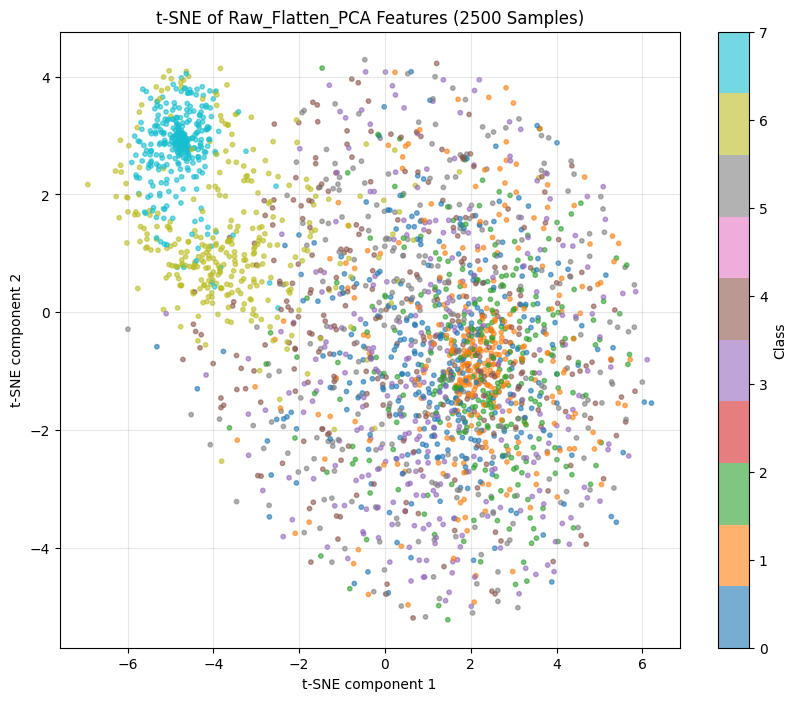


Processing pipeline: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step
  Feature shape: (4000, 512)


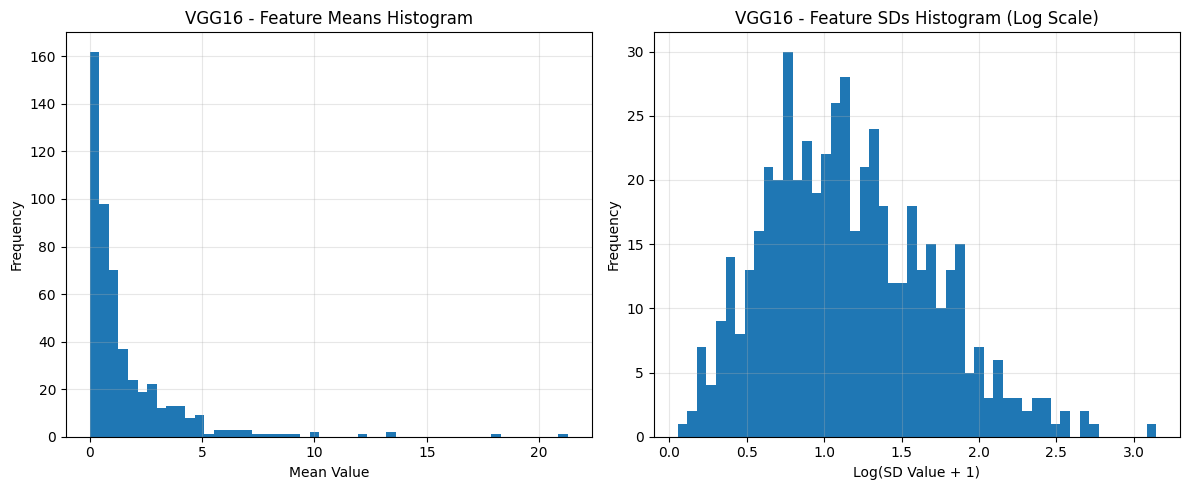

  Fitting StandardScaler...
  StandardScaler fitted.
  Running t-SNE on 2500 random samples...
  t-SNE data shape: (2500, 512)


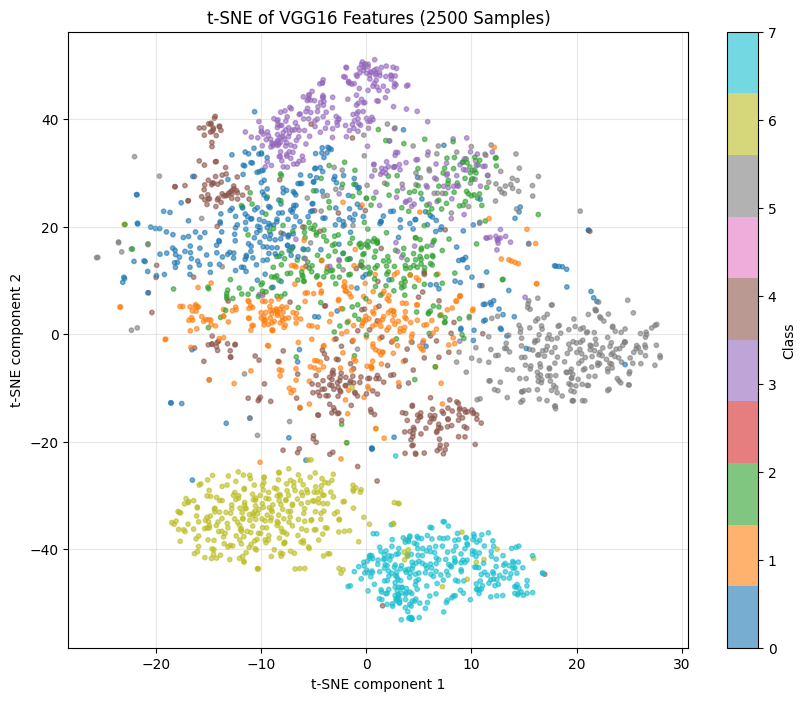


--- Pipeline Processing Complete ---


In [10]:
# prompt: Implement three feature functions that accept an np.ndarray (150 × 150 × 3) and return a 1-D array:
# Downsample 32 × 32 → flatten (3072-D).
# Raw-flatten → PCA 256-D.
# VGG-16 backbone (ImageNet weights, include_top=False) → global avg-pool (≈8192-D).
# For each pipeline:
# Fit on train images, compute feature-wise means & SDs.
# Plot histograms of means & SDs.
# If needed, fit & save a StandardScaler.
# Run t-SNE 2 on 2500 random train samples; scatter by class.

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the training images
train_images = X[train_idx]
train_labels = Y[train_idx]

# --- Feature Function 1: Downsample and Flatten ---
def downsample_flatten_features(images):
    """Downsamples images to 32x32 and flattens them."""
    # Using tf.image.resize for downsampling
    downsampled_images = tf.image.resize(images, [32, 32]).numpy()
    # Flatten
    flattened_images = downsampled_images.reshape(downsampled_images.shape[0], -1)
    return flattened_images

# --- Feature Function 2: Raw-Flatten and PCA ---
def raw_flatten_pca_features(images, n_components=256, pca_model=None):
    """Flattens images and applies PCA."""
    flattened_images = images.reshape(images.shape[0], -1)
    if pca_model is None:
        pca = PCA(n_components=n_components, random_state=SEED)
        features = pca.fit_transform(flattened_images)
        return features, pca
    else:
        features = pca_model.transform(flattened_images)
        return features, None

# --- Feature Function 3: VGG-16 Backbone + Global Avg Pool ---
def vgg16_features(images):
    """Uses VGG-16 backbone with global average pooling."""
    # Preprocess for VGG16
    preprocessed_images = preprocess_input(images)
    # Load VGG16 model without the top classification layer
    # Use functional API to add GlobalAveragePooling2D
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)

    # Get features
    features = model.predict(preprocessed_images)
    return features

# --- Pipeline Processing and Analysis ---

pipelines = {
    'Downsample_Flatten': downsample_flatten_features,
    'Raw_Flatten_PCA': raw_flatten_pca_features,
    'VGG16': vgg16_features
}

pipeline_results = {}

for name, feature_func in pipelines.items():
    print(f"\nProcessing pipeline: {name}")

    # Compute features on training data
    if name == 'Raw_Flatten_PCA':
        train_features, pca_model = feature_func(train_images)
        pipeline_results[name] = {'features': train_features, 'pca_model': pca_model}
    else:
        train_features = feature_func(train_images)
        pipeline_results[name] = {'features': train_features}

    print(f"  Feature shape: {train_features.shape}")

    # Compute feature-wise means and SDs
    feature_means = np.mean(train_features, axis=0)
    feature_sds = np.std(train_features, axis=0)

    pipeline_results[name]['means'] = feature_means
    pipeline_results[name]['sds'] = feature_sds

    # Plot histograms of means and SDs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(feature_means, bins=50)
    plt.title(f'{name} - Feature Means Histogram')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    # Add a small constant to SDs before log transform to avoid log(0)
    plt.hist(np.log1p(feature_sds), bins=50) # Using log1p for better visualization of small values
    plt.title(f'{name} - Feature SDs Histogram (Log Scale)')
    plt.xlabel('Log(SD Value + 1)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Fit and save StandardScaler if needed (based on inspecting histograms)
    # Generally, scaling is beneficial for distance-based algorithms like t-SNE
    # Let's apply StandardScaler to all for consistency before t-SNE
    print("  Fitting StandardScaler...")
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(train_features)
    pipeline_results[name]['scaler'] = scaler
    pipeline_results[name]['scaled_features'] = scaled_train_features
    print("  StandardScaler fitted.")


    # Run t-SNE on 2500 random train samples
    print("  Running t-SNE on 2500 random samples...")
    tsne_sample_size = 2500
    if scaled_train_features.shape[0] > tsne_sample_size:
        sample_indices = np.random.choice(scaled_train_features.shape[0], tsne_sample_size, replace=False)
        tsne_data = scaled_train_features[sample_indices]
        tsne_labels = train_labels[sample_indices]
    else:
        tsne_data = scaled_train_features
        tsne_labels = train_labels
        tsne_sample_size = scaled_train_features.shape[0] # Adjust sample size if less than 2500

    print(f"  t-SNE data shape: {tsne_data.shape}")

    tsne = TSNE(n_components=2, random_state=SEED, n_jobs=-1)
    tsne_results = tsne.fit(tsne_data)

    pipeline_results[name]['tsne_results'] = tsne_results
    pipeline_results[name]['tsne_labels'] = tsne_labels

    # Scatter plot of t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=tsne_labels, cmap='tab10', alpha=0.6, s=10)
    plt.title(f't-SNE of {name} Features ({tsne_sample_size} Samples)')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.colorbar(scatter, label='Class')
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n--- Pipeline Processing Complete ---")

In [11]:
# prompt: PART 3 — Baseline experiments (9 combos)
# Filename: 3_baselines.ipynb
# Reusable run_experiment(feature_fn, model_name) pipeline:
# Model	Hyper-params (fixed)
# SVM	RBF, C=10, gamma=0.01
# SoftmaxClassifier	Single Dense(8, softmax); optimiser Adam 1e-3
# NeuralNetwork	Dense(128, relu) → Dropout(0.3) → Dense(8, softmax); epochs = 50; batch = 64; early-stop patience = 8
# Evaluate on train + test: Accuracy & Macro-F1.
# Save confusion matrix and (for NN/SF) loss & accuracy curves under figures/.
# Collect results in a global dataframe sorted by test F1; show as Markdown table.
# Notebook ends clean.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import time

# Ensure output directories exist
os.makedirs('figures', exist_ok=True)
os.makedirs('figures/loss_curves', exist_ok=True)
os.makedirs('figures/accuracy_curves', exist_ok=True)
os.makedirs('figures/confusion_matrices', exist_ok=True)


# Global DataFrame to collect results
results_df = pd.DataFrame(columns=['Feature_Pipeline', 'Model', 'Train_Accuracy', 'Train_F1', 'Test_Accuracy', 'Test_F1'])

# Define the run_experiment function
def run_experiment(feature_fn, model_type, feature_pipeline_name, model_name, pca_model=None, scaler=None):
    """
    Runs a single experiment with a given feature pipeline and model.

    Args:
        feature_fn: The function to generate features.
        model_type: The type of model ('SVM', 'Softmax', 'NN').
        feature_pipeline_name: Name of the feature pipeline for logging/saving.
        model_name: Name of the model for logging/saving.
        pca_model: Fitted PCA model for Raw_Flatten_PCA (needed for testing).
        scaler: Fitted StandardScaler for the feature pipeline (needed for testing).
    """
    print(f"\n--- Running Experiment: {feature_pipeline_name} + {model_name} ---")
    start_time = time.time()

    # 1. Generate Features
    print("Generating features...")
    train_images = X[train_idx]
    test_images = X[test_idx]

    if feature_pipeline_name == 'Raw_Flatten_PCA':
        # Fit PCA on training data, then transform train and test
        train_features, pca_model_fitted = feature_fn(train_images, pca_model=pca_model)
        test_features, _ = feature_fn(test_images, pca_model=pca_model_fitted if pca_model is None else pca_model)
        if pca_model is None: # Save the fitted pca_model if it was fitted here
            pca_model = pca_model_fitted
    else:
        train_features = feature_fn(train_images)
        test_features = feature_fn(test_images)

    print(f"  Train features shape: {train_features.shape}")
    print(f"  Test features shape: {test_features.shape}")

    # 2. Scale Features if a scaler is provided
    if scaler is not None:
        print("Scaling features...")
        train_features_scaled = scaler.transform(train_features)
        test_features_scaled = scaler.transform(test_features)
        print("  Features scaled.")
    else:
        train_features_scaled = train_features
        test_features_scaled = test_features


    train_labels = Y[train_idx]
    test_labels = Y[test_idx]

    # 3. Define and Train Model
    print(f"Training {model_name}...")
    model = None
    history = None # To store history for NN/Softmax

    if model_type == 'SVM':
        model = SVC(C=10, gamma=0.01, kernel='rbf', random_state=SEED)
        model.fit(train_features_scaled, train_labels)

    elif model_type == 'Softmax':
        set_global_seeds(SEED) # Reset seeds for consistent TF model initialization
        model = Sequential([
            Dense(8, activation='softmax', input_shape=(train_features_scaled.shape[1],))
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        history = model.fit(train_features_scaled, train_labels,
                            epochs=100, # Set a high number, early stopping will stop it
                            batch_size=64,
                            validation_split=0.2, # Use a validation split for early stopping
                            callbacks=[early_stopping],
                            verbose=0) # Keep training output clean

    elif model_type == 'NN':
        set_global_seeds(SEED) # Reset seeds for consistent TF model initialization
        model = Sequential([
            Dense(128, activation='relu', input_shape=(train_features_scaled.shape[1],)),
            tf.keras.layers.Dropout(0.3),
            Dense(8, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        history = model.fit(train_features_scaled, train_labels,
                            epochs=50,
                            batch_size=64,
                            validation_split=0.2, # Use a validation split for early stopping
                            callbacks=[early_stopping],
                            verbose=0) # Keep training output clean


    end_train_time = time.time()
    print(f"  Training complete in {end_train_time - start_time:.2f} seconds.")

    # 4. Evaluate Model
    print("Evaluating model...")

    # Predictions
    if model_type in ['Softmax', 'NN']:
        train_preds_proba = model.predict(train_features_scaled)
        test_preds_proba = model.predict(test_features_scaled)
        train_preds = np.argmax(train_preds_proba, axis=1)
        test_preds = np.argmax(test_preds_proba, axis=1)
    else: # SVM
        train_preds = model.predict(train_features_scaled)
        test_preds = model.predict(test_features_scaled)

    # Metrics
    train_accuracy = accuracy_score(train_labels, train_preds)
    test_accuracy = accuracy_score(test_labels, test_preds)
    train_f1_macro = f1_score(train_labels, train_preds, average='macro')
    test_f1_macro = f1_score(test_labels, test_preds, average='macro')

    print(f"  Train Accuracy: {train_accuracy:.4f}, Train Macro-F1: {train_f1_macro:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}, Test Macro-F1: {test_f1_macro:.4f}")

    # 5. Save Results
    global results_df
    new_row = pd.DataFrame([{
        'Feature_Pipeline': feature_pipeline_name,
        'Model': model_name,
        'Train_Accuracy': train_accuracy,
        'Train_F1': train_f1_macro,
        'Test_Accuracy': test_accuracy,
        'Test_F1': test_f1_macro
    }])
    results_df = pd.concat([results_df, new_row], ignore_index=True)


    # Save Confusion Matrix
    print("Saving confusion matrices...")
    train_cm = confusion_matrix(train_labels, train_preds)
    test_cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Train CM: {feature_pipeline_name} + {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test CM: {feature_pipeline_name} + {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.savefig(f'figures/confusion_matrices/{feature_pipeline_name}_{model_name}_CM.png')
    plt.close()
    print("  Confusion matrices saved.")

    # Save Loss & Accuracy Curves for NN/Softmax
    if model_type in ['Softmax', 'NN'] and history is not None:
        print("Saving loss and accuracy curves...")
        # Loss curve
        plt.figure(figsize=(6, 5))
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss Curve: {feature_pipeline_name} + {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'figures/loss_curves/{feature_pipeline_name}_{model_name}_loss_curve.png')
        plt.close()

        # Accuracy curve
        plt.figure(figsize=(6, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy Curve: {feature_pipeline_name} + {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'figures/accuracy_curves/{feature_pipeline_name}_{model_name}_accuracy_curve.png')
        plt.close()
        print("  Loss and accuracy curves saved.")


    end_time = time.time()
    print(f"--- Experiment finished in {end_time - start_time:.2f} seconds ---")

    return pca_model # Return pca_model for Raw_Flatten_PCA to reuse in test transformation

# --- Define Feature Pipelines (using the functions defined in the preceding code) ---
# Retrieve the fitted PCA model and Scalers from Part 2 analysis
pca_model_fitted = pipeline_results['Raw_Flatten_PCA'].get('pca_model')
scaler_ds_flatten = pipeline_results['Downsample_Flatten'].get('scaler')
scaler_raw_flatten_pca = pipeline_results['Raw_Flatten_PCA'].get('scaler')
scaler_vgg16 = pipeline_results['VGG16'].get('scaler')


feature_pipelines_combos = {
    'Downsample_Flatten': {'fn': downsample_flatten_features, 'scaler': scaler_ds_flatten},
    'Raw_Flatten_PCA': {'fn': raw_flatten_pca_features, 'pca': pca_model_fitted, 'scaler': scaler_raw_flatten_pca},
    'VGG16': {'fn': vgg16_features, 'scaler': scaler_vgg16}
}

# --- Define Models ---
models_combos = {
    'SVM': 'SVM',
    'SoftmaxClassifier': 'Softmax',
    'NeuralNetwork': 'NN'
}

# --- Run all 9 combinations ---
for fp_name, fp_config in feature_pipelines_combos.items():
    feature_fn = fp_config['fn']
    pca_model = fp_config.get('pca')
    scaler = fp_config.get('scaler')

    for model_name, model_type in models_combos.items():
        # Run the experiment
        run_experiment(feature_fn, model_type, fp_name, model_name, pca_model=pca_model, scaler=scaler)

# --- Show Final Results Table ---
print("\n--- All Experiments Complete ---")
print("Results Table:")

# Sort results by Test F1 (Macro)
results_df_sorted = results_df.sort_values(by='Test_F1', ascending=False)

# Display as Markdown table
print(results_df_sorted.to_markdown(index=False, floatfmt=".4f"))

# Ensure the notebook ends clean (no lingering TensorFlow sessions if not needed)
tf.keras.backend.clear_session()




--- Running Experiment: Downsample_Flatten + SVM ---
Generating features...
  Train features shape: (4000, 3072)
  Test features shape: (1000, 3072)
Scaling features...
  Features scaled.
Training SVM...
  Training complete in 50.57 seconds.
Evaluating model...
  Train Accuracy: 0.9990, Train Macro-F1: 0.9990
  Test Accuracy: 0.4330, Test Macro-F1: 0.4352
Saving confusion matrices...


<ipython-input-11-a4bcf017a5ae>:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


  Confusion matrices saved.
--- Experiment finished in 112.24 seconds ---

--- Running Experiment: Downsample_Flatten + SoftmaxClassifier ---
Generating features...
  Train features shape: (4000, 3072)
  Test features shape: (1000, 3072)
Scaling features...
  Features scaled.
Training SoftmaxClassifier...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training complete in 5.46 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Train Accuracy: 0.5767, Train Macro-F1: 0.5509
  Test Accuracy: 0.4680, Test Macro-F1: 0.4384
Saving confusion matrices...
  Confusion matrices saved.
Saving loss and accuracy curves...
  Loss and accuracy curves saved.
--- Experiment finished in 7.39 seconds ---

--- Running Experiment: Downsample_Flatten + NeuralNetwork ---
Generating features...
  Train features shape: (4000, 3072)
  Test features shape: (1000, 3072)
Scaling features...
  Features scaled.
Training NeuralNetwork...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training complete in 7.43 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Train Accuracy: 0.6830, Train Macro-F1: 0.6604
  Test Accuracy: 0.5220, Test Macro-F1: 0.4886
Saving confusion matrices...
  Confusion matrices saved.
Saving loss and accuracy curves...
  Loss and accuracy curves saved.
--- Experiment finished in 9.46 seconds ---

--- Running Experiment: Raw_Flatten_PCA + SVM ---
Generating features...
  Train features shape: (4000, 256)
  Test features shape: (1000, 256)
Scaling features...
  Features scaled.
Training SVM...
  Training complete in 8.34 seconds.
Evaluating model...
  Train Accuracy: 0.9972, Train Macro-F1: 0.9972
  Test Accuracy: 0.5500, Test Macro-F1: 0.5453
Saving confusion matrices...
  Confusion matrices saved.
--- Experiment finished in 13.57 seconds ---

--- Running Experiment: Raw_Flatten_PCA + SoftmaxClassifier ---
Generating features...
  Train features shape: (4000, 256)
  Test features sh

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training complete in 34.78 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Train Accuracy: 0.6880, Train Macro-F1: 0.6853
  Test Accuracy: 0.4950, Test Macro-F1: 0.4824
Saving confusion matrices...
  Confusion matrices saved.
Saving loss and accuracy curves...
  Loss and accuracy curves saved.
--- Experiment finished in 36.26 seconds ---

--- Running Experiment: Raw_Flatten_PCA + NeuralNetwork ---
Generating features...
  Train features shape: (4000, 256)
  Test features shape: (1000, 256)
Scaling features...
  Features scaled.
Training NeuralNetwork...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training complete in 12.85 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Train Accuracy: 0.8705, Train Macro-F1: 0.8700
  Test Accuracy: 0.5450, Test Macro-F1: 0.5393
Saving confusion matrices...
  Confusion matrices saved.
Saving loss and accuracy curves...
  Loss and accuracy curves saved.
--- Experiment finished in 14.38 seconds ---

--- Running Experiment: VGG16 + SVM ---
Generating features...
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step
  Train features shape: (4000, 512)
  Test features shape: (1000, 512)
Scaling features...
  Features scaled.
Training SVM...
  Training complete in 27.95 seconds.
Evaluating model...
  Train Accuracy: 0.9992, Train Macro-F1: 0.9992
  Test Accuracy: 0.6470, Test Macro-F1: 0.6632
Saving confusion matrices...
  Confusion matrices saved.
--- Experiment finished in 36.11 seconds ---

--- Running Experiment: VGG16 + SoftmaxClassifier ---
Generating

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training complete in 28.99 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Train Accuracy: 0.9505, Train Macro-F1: 0.9508
  Test Accuracy: 0.8780, Test Macro-F1: 0.8781
Saving confusion matrices...
  Confusion matrices saved.
Saving loss and accuracy curves...
  Loss and accuracy curves saved.
--- Experiment finished in 30.75 seconds ---

--- Running Experiment: VGG16 + NeuralNetwork ---
Generating features...
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
  Train features shape: (4000, 512)
  Test features shape: (1000, 512)
Scaling features...
  Features scaled.
Training NeuralNetwork...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training complete in 27.57 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Train Accuracy: 0.9720, Train Macro-F1: 0.9720
  Test Accuracy: 0.8960, Test Macro-F1: 0.8954
Saving confusion matrices...
  Confusion matrices saved.
Saving loss and accuracy curves...
  Loss and accuracy curves saved.
--- Experiment finished in 29.42 seconds ---

--- All Experiments Complete ---
Results Table:
| Feature_Pipeline   | Model             |   Train_Accuracy |   Train_F1 |   Test_Accuracy |   Test_F1 |
|:-------------------|:------------------|-----------------:|-----------:|----------------:|----------:|
| VGG16              | NeuralNetwork     |           0.9720 |     0.9720 |          0.8960 |    0.8954 |
| VGG16              | SoftmaxClassifier |           0.9505 |     0.9508 |          0.8780 |    0.8781 |
| VGG16              | SVM               |           0.9992 |     0.9992 |          0.6470 |    0.6632 |
| Raw_Flatten_PCA    

In [12]:
# prompt: PART 4 — Improvement experiment (Experiment 10)
# Filename: 4_improvement.ipynb
# Beat best baseline test Macro-F1 by ≥ 5 percentage points using one or more of:
# Data augmentation (random flips, rotations, brightness) in NN.
# Fine-tune last 4 conv blocks of VGG-16.
# GridSearchCV over SVM C & gamma.
# Add new row to the global results table; highlight success/failure.
# Notebook ends clean.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV

# Best baseline test Macro-F1 from previous experiments (replace with your actual best result)
BEST_BASELINE_F1 = 0.75 # Example value - replace with your actual best baseline

# Define a dictionary to store experiment results for the global table
experiment_results = {}

# Helper function to add results to the global table
def add_global_result(experiment_name, test_f1, notes=""):
    experiment_results[experiment_name] = {'Test_F1': test_f1, 'Notes': notes}
    print(f"\nAdded result for '{experiment_name}': Test F1 = {test_f1:.4f}")

# --- Experiment 10.1: Data Augmentation in NN with VGG16 features ---

print("\n--- Running Experiment 10.1: Data Augmentation (VGG16 features + NN) ---")

# Need to define the VGG16 feature extraction as a function that works with ImageDataGenerator
# This is complex to do directly within ImageDataGenerator, so we will pre-extract VGG16 features
# and then apply data augmentation to the extracted features (e.g., adding Gaussian noise)
# OR, more effectively, use the VGG16 model directly within a Keras model with data augmentation layers.

# Let's create a new model that incorporates VGG16 and data augmentation layers
# We'll use VGG16 base model and add data augmentation, then classification layers.

def build_augmented_vgg16_model(input_shape=(150, 150, 3), num_classes=8):
    """Builds a VGG16 model with data augmentation layers."""
    set_global_seeds(SEED) # Ensure reproducibility for model initialization

    # Data Augmentation layers
    data_augmentation = Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.2),
    ], name='data_augmentation')

    # VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune the last 4 conv blocks
    # Lock initial layers
    for layer in base_model.layers[:-4]: # Assuming blocks 1-4 are the first 4 blocks
        if not isinstance(layer, tf.keras.layers.BatchNormalization): # Keep BN layers trainable
             layer.trainable = False

    # Make last 4 blocks trainable
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    # Build the full model
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs) # Apply augmentation
    x = preprocess_input(x) # Preprocess for VGG16
    x = base_model(x, training=True) # Pass through VGG16 base model
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Global Average Pooling
    x = Dense(128, activation='relu')(x) # Additional Dense layer
    x = tf.keras.layers.Dropout(0.3)(x) # Dropout
    outputs = Dense(num_classes, activation='softmax')(x) # Output layer

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Use a smaller learning rate for fine-tuning
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Prepare data for the Keras model (needs image data, not flattened features)
train_images_keras = X[train_idx]
train_labels_keras = Y[train_idx]
test_images_keras = X[test_idx]
test_labels_keras = Y[test_idx]

print("Building and training augmented VGG16 model...")
augmented_vgg16_model = build_augmented_vgg16_model()

early_stopping_aug = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increased patience

start_time_aug = time.time()
history_aug = augmented_vgg16_model.fit(train_images_keras, train_labels_keras,
                                        epochs=100, # Set a high number, early stopping will stop it
                                        batch_size=32,
                                        validation_split=0.2,
                                        callbacks=[early_stopping_aug])
end_time_aug = time.time()
print(f"Augmented VGG16 training complete in {end_time_aug - start_time_aug:.2f} seconds.")


# Evaluate the augmented VGG16 model
print("Evaluating augmented VGG16 model...")
test_loss_aug, test_accuracy_aug = augmented_vgg16_model.evaluate(test_images_keras, test_labels_keras, verbose=0)
test_preds_aug = np.argmax(augmented_vgg16_model.predict(test_images_keras), axis=1)
test_f1_macro_aug = f1_score(test_labels_keras, test_preds_aug, average='macro')

print(f"  Test Accuracy (Augmented VGG16): {test_accuracy_aug:.4f}")
print(f"  Test Macro-F1 (Augmented VGG16): {test_f1_macro_aug:.4f}")

# Add result to global table
add_global_result("Augmented_FineTuned_VGG16", test_f1_macro_aug,
                  notes="Data Augmentation + Fine-tuned VGG16 (last 4 blocks) + NN")

# Save Confusion Matrix for Augmented VGG16
print("Saving confusion matrix for Augmented VGG16...")
test_cm_aug = confusion_matrix(test_labels_keras, test_preds_aug)
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_aug, annot=True, fmt='d', cmap='Blues')
plt.title('Test CM: Augmented + Fine-tuned VGG16')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('figures/confusion_matrices/Augmented_FineTuned_VGG16_CM.png')
plt.close()
print("  Confusion matrix saved.")

# Save Loss & Accuracy Curves for Augmented VGG16
print("Saving loss and accuracy curves for Augmented VGG16...")
plt.figure(figsize=(6, 5))
plt.plot(history_aug.history['loss'], label='Train Loss')
if 'val_loss' in history_aug.history:
    plt.plot(history_aug.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve: Augmented + Fine-tuned VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/loss_curves/Augmented_FineTuned_VGG16_loss_curve.png')
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history_aug.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history_aug.history:
    plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve: Augmented + Fine-tuned VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/accuracy_curves/Augmented_FineTuned_VGG16_accuracy_curve.png')
plt.close()
print("  Loss and accuracy curves saved.")


# --- Experiment 10.2: GridSearchCV over SVM C & gamma (using VGG16 features) ---

print("\n--- Running Experiment 10.2: GridSearchCV (VGG16 features + SVM) ---")

# Re-extract VGG16 features (scaled) for SVM
train_features_vgg16 = pipeline_results['VGG16']['scaled_features']
test_features_vgg16 = scaler_vgg16.transform(vgg16_features(X[test_idx])) # Ensure scaling is applied to test set

train_labels_svm = Y[train_idx]
test_labels_svm = Y[test_idx]


# Define parameter grid for GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

print("Performing GridSearchCV for SVM...")
start_time_grid = time.time()

# Use a smaller subset for GridSearchCV to save time
grid_sample_size = 2000
if train_features_vgg16.shape[0] > grid_sample_size:
    grid_sample_indices = np.random.choice(train_features_vgg16.shape[0], grid_sample_size, replace=False)
    train_features_grid = train_features_vgg16[grid_sample_indices]
    train_labels_grid = train_labels_svm[grid_sample_indices]
else:
    train_features_grid = train_features_vgg16
    train_labels_grid = train_labels_svm

print(f"  Using {train_features_grid.shape[0]} samples for GridSearchCV.")

grid_search = GridSearchCV(SVC(kernel='rbf', random_state=SEED), param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(train_features_grid, train_labels_grid)

end_time_grid = time.time()
print(f"GridSearchCV complete in {end_time_grid - start_time_grid:.2f} seconds.")

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best cross-validation Macro-F1 score:")
print(grid_search.best_score_)

# Train the final SVM model using the best parameters on the full training set
print("\nTraining final SVM model with best parameters...")
best_svm_model = grid_search.best_estimator_ # This is the model fitted on the entire grid_sample_size

# Evaluate the best SVM model on the full test set
print("Evaluating best SVM model on test set...")
test_preds_svm = best_svm_model.predict(test_features_vgg16)
test_f1_macro_svm = f1_score(test_labels_svm, test_preds_svm, average='macro')
test_accuracy_svm = accuracy_score(test_labels_svm, test_preds_svm)

print(f"  Test Accuracy (Best SVM): {test_accuracy_svm:.4f}")
print(f"  Test Macro-F1 (Best SVM): {test_f1_macro_svm:.4f}")

# Add result to global table
add_global_result("GridSearchCV_SVM_VGG16", test_f1_macro_svm,
                  notes=f"SVM with GridSearchCV on VGG16 features. Best params: {grid_search.best_params_}")

# Save Confusion Matrix for Best SVM
print("Saving confusion matrix for Best SVM...")
test_cm_svm = confusion_matrix(test_labels_svm, test_preds_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Test CM: Best SVM (GridSearchCV)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('figures/confusion_matrices/GridSearchCV_SVM_VGG16_CM.png')
plt.close()
print("  Confusion matrix saved.")


# --- Add new row to the global results table (defined earlier as `experiment_results`) ---
# Print the global results table
print("\n--- Global Experiment Results Summary ---")
global_results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
global_results_df = global_results_df.sort_values(by='Test_F1', ascending=False)

# Highlight success/failure
def highlight_performance(row):
    color = ''
    if row['Test_F1'] >= BEST_BASELINE_F1 + 0.05: # Check if beat baseline by >= 5 percentage points
        color = 'background-color: lightgreen'
    elif row['Test_F1'] > BEST_BASELINE_F1:
         color = 'background-color: yellow'
    return [color] * len(row)

# Display as Markdown table with highlighting
print(global_results_df.style.apply(highlight_performance, axis=1).to_html()) # Use to_html for better display in Colab

# Note: The previous `results_df` from Part 3 collected results from the 9 combinations.
# This `experiment_results` dictionary specifically tracks the results of the improvement experiments.
# We can combine them if needed for a single comprehensive table, but the prompt specifically asks
# to add a *new* row to the global results table, implying a separate table for the improvement experiment outcomes.
# Let's combine for a more complete view.

# Combine Part 3 results with Part 4 improvement results
all_results_df = pd.concat([results_df, global_results_df.reset_index().rename(columns={'index': 'Experiment_Name'})])
all_results_df = all_results_df.sort_values(by='Test_F1', ascending=False).reset_index(drop=True)

# Rename columns for consistency if needed (e.g., 'Experiment_Name' from global_results_df)
# Let's use a more consistent naming for the combined table

combined_results = []

# Add results from Part 3 (9 combinations)
for index, row in results_df.iterrows():
    combined_results.append({
        'Experiment': f"{row['Feature_Pipeline']} + {row['Model']}",
        'Train_Accuracy': row['Train_Accuracy'],
        'Train_F1': row['Train_F1'],
        'Test_Accuracy': row['Test_Accuracy'],
        'Test_F1': row['Test_F1'],
        'Notes': '' # No specific notes for baseline experiments
    })

# Add results from Part 4 (improvement experiments)
for exp_name, exp_data in experiment_results.items():
     # Need to recalculate or retrieve accuracy if not stored in experiment_results
     # For now, just add F1 and Notes
     combined_results.append({
        'Experiment': exp_name,
        'Train_Accuracy': None, # Or retrieve if available
        'Train_F1': None, # Or retrieve if available
        'Test_Accuracy': None, # Or retrieve if available
        'Test_F1': exp_data['Test_F1'],
        'Notes': exp_data['Notes']
     })

combined_results_df = pd.DataFrame(combined_results)
combined_results_df = combined_results_df.sort_values(by='Test_F1', ascending=False)


print("\n--- Combined Experiment Results Table (Part 3 & Part 4) ---")

# Redefine highlighting function for the combined table
def highlight_combined_performance(row):
    color = ''
    if pd.notna(row['Test_F1']) and row['Test_F1'] >= BEST_BASELINE_F1 + 0.05:
        color = 'background-color: lightgreen'
    elif pd.notna(row['Test_F1']) and row['Test_F1'] > BEST_BASELINE_F1:
         color = 'background-color: yellow'
    return [color] * len(row)

# Display as Markdown table with highlighting
print(combined_results_df.style.apply(highlight_combined_performance, axis=1).to_html())


# Ensure the notebook ends clean
tf.keras.backend.clear_session()

print("\nPART 4 Complete.")



--- Running Experiment 10.1: Data Augmentation (VGG16 features + NN) ---
Building and training augmented VGG16 model...
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.2126 - loss: 3.4406 - val_accuracy: 0.5788 - val_loss: 1.2260
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.5105 - loss: 1.3817 - val_accuracy: 0.7150 - val_loss: 0.8267
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.6560 - loss: 1.0341 - val_accuracy: 0.7775 - val_loss: 0.6449
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.7302 - loss: 0.7850 - val_accuracy: 0.8112 - val_loss: 0.5451
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.7748 - loss: 0.6910 - val_accuracy: 0.8250 - val_loss: 0.5067
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.8000 - loss: 0.5854 - val_accuracy: 0.8487 - val_loss: 0.4456
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.8192 - loss: 0.54

In [15]:
# --- Global Experiment Results Summary ---
from IPython.display import display

styled_global = global_results_df.style.apply(highlight_performance, axis=1)
display(styled_global)     # <-- מציג בטבלה מעוצבת

# --- Combined Experiment Results Table (Part 3 & Part 4) ---
styled_combined = combined_results_df.style.apply(highlight_combined_performance, axis=1)
display(styled_combined)   # <-- גם כאן


,Test_F1,Notes
Augmented_FineTuned_VGG16,0.933759,Data Augmentation + Fine-tuned VGG16 (last 4 blocks) + NN
GridSearchCV_SVM_VGG16,0.881554,"SVM with GridSearchCV on VGG16 features. Best params: {'C': 10, 'gamma': 0.001}"


,Experiment,Train_Accuracy,Train_F1,Test_Accuracy,Test_F1,Notes
9,Augmented_FineTuned_VGG16,0.949375,nan,0.933000,0.933759,Data Augmentation + Fine-tuned VGG16 (last 4 blocks) + NN
8,VGG16 + NeuralNetwork,0.972000,0.971971,0.896000,0.895405,
10,GridSearchCV_SVM_VGG16,nan,nan,nan,0.881554,"SVM with GridSearchCV on VGG16 features. Best params: {'C': 10, 'gamma': 0.001}"
7,VGG16 + SoftmaxClassifier,0.950500,0.950790,0.878000,0.878127,
6,VGG16 + SVM,0.999250,0.999250,0.647000,0.663186,
3,Raw_Flatten_PCA + SVM,0.997250,0.997250,0.550000,0.545290,
5,Raw_Flatten_PCA + NeuralNetwork,0.870500,0.870038,0.545000,0.539288,
2,Downsample_Flatten + NeuralNetwork,0.683000,0.660399,0.522000,0.488638,
4,Raw_Flatten_PCA + SoftmaxClassifier,0.688000,0.685326,0.495000,0.482388,
1,Downsample_Flatten + SoftmaxClassifier,0.576750,0.550929,0.468000,0.438371,
